In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import cv2
import joblib
from tqdm.notebook import tqdm
import tensorflow as tf

In [49]:
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, auc, accuracy_score, roc_curve, RocCurveDisplay, confusion_matrix
from sklearn.preprocessing import LabelEncoder, LabelBinarizer,label_binarize
from sklearn.model_selection import GridSearchCV, train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [50]:
train_labels = pd.read_csv("/kaggle/input/raf-db-dataset/train_labels.csv")
test_labels = pd.read_csv("/kaggle/input/raf-db-dataset/test_labels.csv")

In [51]:
train_labels.head()

,image,label
0,train_00001_aligned.jpg,5
1,train_00002_aligned.jpg,5
2,train_00003_aligned.jpg,4
3,train_00004_aligned.jpg,4
4,train_00005_aligned.jpg,5


In [52]:
test_labels.head()

,image,label
0,test_0001_aligned.jpg,5
1,test_0002_aligned.jpg,1
2,test_0003_aligned.jpg,4
3,test_0004_aligned.jpg,1
4,test_0005_aligned.jpg,5


In [53]:
classes = ["surprise","fear","disgust","happy","sad","angry","neutral"]
label_map = {label:(idx+1) for idx,label in enumerate(classes)}
label_map

{'surprise': 1,
 'fear': 2,
 'disgust': 3,
 'happy': 4,
 'sad': 5,
 'angry': 6,
 'neutral': 7}

# Data Balancing and Augmentation

In [54]:
def load_data(dataset_dir, label_map):
    images = []
    labels = []
    for label,idx in tqdm(label_map.items()):
        folder_path = os.path.join(dataset_dir, str(idx))
        for file_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path,file_name)
            img = cv2.imread(img_path)
            rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(rgb_img)
            labels.append(idx)
    return np.array(images), np.array(labels)

In [55]:
train_images, train_labels = load_data("/kaggle/input/raf-db-dataset/DATASET/train",label_map)
test_images, test_labels = load_data("/kaggle/input/raf-db-dataset/DATASET/test", label_map)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [56]:
train_images.shape

(12271, 100, 100, 3)

In [57]:
test_images.shape

(3068, 100, 100, 3)

In [58]:
total_images = len(train_images) + len(test_images)
train_percent = (len(train_images)/total_images)*100
test_percent = (len(test_images)/total_images)*100

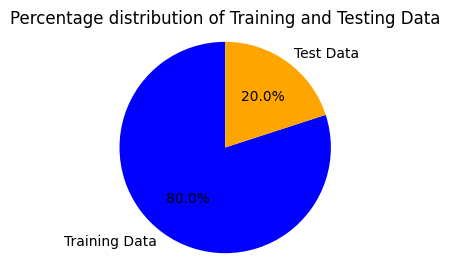

In [59]:
labels = ['Training Data', 'Test Data']
sizes = [train_percent, test_percent]
colors = ['blue', 'orange']
plt.figure(figsize = (3,3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage distribution of Training and Testing Data')
plt.axis('equal')
plt.show()

In [60]:
train_labels_count = Counter(train_labels)
test_labels_count = Counter(test_labels)

train_classes = sorted(train_labels_count.keys())
train_counts = [train_labels_count[cls] for cls in train_classes]

test_classes = sorted(test_labels_count.keys())
test_counts = [test_labels_count[cls] for cls in test_classes]

In [1]:
total_train = sum(train_counts)
total_test = sum(test_counts)
train_per = [(count/total_train)*100 for count in train_counts]
test_per = [(count/total_test)*100 for count in test_counts]
plt.figure(figsize=(8,6))
x = range(len(classes))
bar_width = 0.35

plt.bar(x, train_counts, width=bar_width, lable="Train", alpha=0.7, color = 'blue')
plt.bar([p + bar_width for p in x], test_counts, width=bar_width, lablel="Test", alpha = 0.7, color='red')

for i, (train_count,test_count) in enumerate(zip(train_counts, test_counts)):
    plt.text(i, train_count+0.005 * total_train, f"{train_per[i]:.1f}%", ha=center, color='blue',fontsize=9)
    plt.text(i, test_count+0.005 * total_test, f"{test_per[i]:.1f}%", ha=center, color='red',fontsize=9)

NameError: name 'train_counts' is not defined

In [ ]:
X = np.concatenate([train_images, test_images], axis=0)
Y = np.concatenate([train_labels, test_labels], axis=0)

In [ ]:
X,Y = shuffle(X,Y,random_state=42)

In [3]:

train_data_shapes = []
for img in X:
    train_data_shapes.append(img.shape)

shape_counts = {}
for shape in train_data_shape:
    if shape not in shape_counts:
        shape_counts[shape] = 0
    shape_counts[shape] += 1

sorted_shapes = sorted(shape_counts.items(), key= lambda x: x[1], reverse=True)

print("Most frequent shapes:")
for shape, count in sorted_shapes[:3]:
    print(f"- {shape} : {count}")

SyntaxError: incomplete input (1331363101.py, line 7)

# Data Preprocessing

In [ ]:
def plot_class_distribution(y,title):
    train_label_counts_resampled = Counter(y)

    train_classes_resampled = sorted(train_label_counts_resampled.keys())
    train_counts_resampled = [train_lable_counts_resampled[cls] for cls in train_classes_resampled]

    plt.figure(figsize = (6,3))
    labels = ['Surprise', 'Fear', 'Disgust', 'Happy', 'Sad', 'Angry', 'Neutral']

    plt.bar(x_labels, train_counts_resampled, color = 'blue')

    plt.xlabel("Emotion class")
    plt.ylabel("Number of Examples")
    plt.title(title)
    plt.tight_layout()
    plt.show

plot_class_distribution(Y_train,"Class Distribution")

## Treating Class Imbalance

### Reducing the images in a large class

In [ ]:
def reduce_class(X,y,target_class,target_size):
    class_indicies = np.where(y == target_class)[0]
    non_class_indicies = np.where(y != target_class)[0]
    #randomly sample the target class to the desired size
    reduced_classed_indices = np.random.choice(class_indicies, target_size, replace=False)

    #Combine the reduced class with the other classes
    final_indicies = np.concatenate(reduced_classed_indicies, non_class_indicies)
    X_reduced = X[final_indicies]
    y_reduced = y[final_indicies]

    return X_reduced, y_reduced


target_class = 4
target_size = 3500
X_train_reduced, y_train_reduced = reduce_class(X_train, Y_train, target_class, target_size)
plot_class_distribution(y_train_reduced, "Class Distribution")

### Augementing images to other classes with less images

In [ ]:
def augment_class():
    pass

## Train_test split

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(X_train_augmented, y_train_augmented, test_size = 0.25, suffle=True, random_state=42)

## Image Normalization

In [ ]:
def normalise_images(images):
    return images/255.0

X_train = normalise_images(X_train)
X_test = normalise_images(X_test)

## Image Reshaping

In [ ]:
def reshape_images(images):
    return images.reshape(images.shape[0], 100, 100, 3)
X_train = reshape_images(X_train)
X_test = reshape_images(X_test)

## One Hot Encoding our emotions 

In [ ]:
y_train = to_categorical(y_train - 1, num_classes=len(classes))
y_test = to_categorical(y_test - 1, num_classes=len(classes))

## Data Augmentation while training

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    vertical_flip=False,
    horizontal_filp=True,
    fill_mode='nearest'
)
train_generator = datagen.flow(X_train,y_train,batch_size=64)

# Model Building

## CNN Architecture

In [ ]:
cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(X_train[0].shape))
    MaxPooling2D((2,2))

    Conv2D(64, (3,3), activation='relu')
    MaxPooling2D((2,2))

    Conv2D(128, (3,3), activation='relu')
    MaxPooling2D((2,2))

    Conv2D(512, (3,3), activation='relu')
    MaxPooling2D((2,2))

    Flatten(),
    Dense(512, activation='relu')
    Dropout(0.5),

    Dense(len(classes), activation='softmax')
])

In [ ]:
cnn.compile(optimizer='adam', loss_function='categorical_crossentropy', metrics['accuracy'])

## Training the Model

### Setting up callbacks

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_delta=0.0001, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restor_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint(file_path='best_CNNModel.keras', monitor='val_accuracy', save_best_only=True)

In [ ]:
cnn_history=cnn.fit(train_generator, epochs=10, batch_size=32, validation_data=(X_test,y_test), callbacks=[reduce_lr, early_stop, checkpoint])

### Seeing the training progress

In [ ]:
train_loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']
train_accuracy =  cnn_history.history['accuracy']
val_accuracy =  cnn_history.history['val_accuracy']

fig,ax = plt.subplots(1,2, figsize=(8,4))

# Loss Plot
ax[0].plot(train_loss, label="train_loss", color='red')
ax[0].plot(val_loss, label="val_loss", color='blue')
ax[0].set_title('Loss Curve')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_ylim([0,2]) #Y-axis range
ax[0].grid(alpha=0.3)

#AccuracyPlot
ax[0].plot(train_accuracy, label="train_accuracy", color='red')
ax[0].plot(val_accuracy, label="val_accuracy", color='blue')
ax[0].set_title('Accuracy Curve')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].set_ylim([0,2]) #Y-axis range
ax[0].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Model Evaluation